### Bias-Variance Tradeoff
* The purpose of this notebook is to illustrate the "bias-variance tradeoff" or "bias-variance dilemma", an important concept in statistics which concerns the tradeoff between bias (i.e. in-sample error) and variance (i.e. the change in estimate between training and validation sets) as statistical model complexity is varied.  

* The bias-variance tradeoff consists in the need to minimise these two sources of error, the variance and bias of an estimator, in order to minimise the mean squared error. Sometimes there is a tradeoff between minimising bias and minimising variance to achieve the least possible MSE. The bias-variance tradeoff explains why complex models tend to over-fit the training data and overly simple models may underfit the training data.

* In this notebook, various polynomial regression models are compared. Each input, $x$, denotes an angle in radians and the output is a noisy trigonometric function $y=1-\cos(x) + x + \epsilon$, where $\epsilon$ is Gaussian noise. The regression model is of the form $\hat{y}= \beta_0 + \beta_1x + \dots + \beta_nx^n$. 200 training samples are generated for training and 80 samples are used for out-of-sample testing.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 10

Define input arrays with angles between 0 and 400 degrees converted to radians

In [2]:
np.random.seed(10)

in_sample_x = np.pi / 180 * np.random.uniform(0, 400, size=200)
out_sample_x = np.pi / 180 * np.random.uniform(0, 400, size=80)

in_sample_x = np.sort(in_sample_x)
out_sample_x = np.sort(out_sample_x)

Define output arrays containing the corresponding values of $y=1-\cos(x) + x + \epsilon$

In [3]:
in_sample_y = 1 - np.cos(in_sample_x) + in_sample_x + np.random.normal(0, 0.6, len(in_sample_x))
out_sample_y = 1 - np.cos(out_sample_x) + out_sample_x + np.random.normal(0, 0.6, len(out_sample_x))

data_in = pd.DataFrame(np.column_stack([in_sample_x, in_sample_y]), columns=['x', 'y'])
data_out = pd.DataFrame(np.column_stack([out_sample_x, out_sample_y]), columns=['x', 'y'])

Plot the datasets

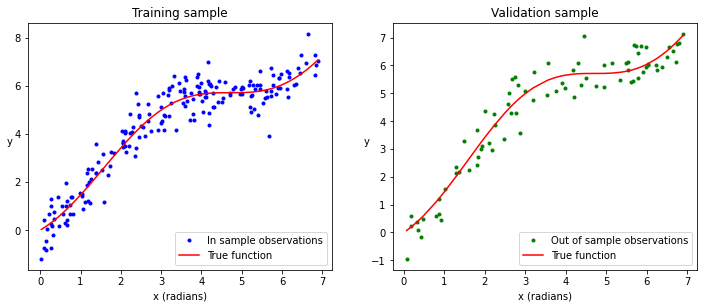

In [4]:
plt.figure(1)
plt.subplot(221)
plt.plot(data_in['x'], data_in['y'], '.', color='blue', label="In sample observations")
plt.plot(data_in['x'], 1 - np.cos(in_sample_x) + in_sample_x, color='red', label="True function")
plt.legend(loc = "lower right")
plt.title('Training sample')
plt.xlabel('x (radians)')
plt.ylabel('y', rotation=0)
plt.subplot(222)
plt.plot(data_out['x'], data_out['y'], '.', color='green', label="Out of sample observations")
plt.plot(data_out['x'], 1 - np.cos(out_sample_x) + out_sample_x, color='red', label="True function")
plt.title('Validation sample')
plt.xlabel('x (radians)')
plt.ylabel('y', rotation=0)
plt.legend(loc = "lower right");

Add a column to the training and validation datasets containing each of the monomials up to the 39th power

In [5]:
for i in range(2,40): # (Power of 1 is already there)
    colname = 'x_%d' % i # New var will be x_power
    data_in[colname] = data_in['x']**i
    data_out[colname] = data_out['x']**i

data_out.head()

,x,y,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_30,x_31,x_32,x_33,x_34,x_35,x_36,x_37,x_38,x_39
0,0.064375,-0.941821,0.004144,0.000267,0.000017,0.000001,7.117394e-08,4.581853e-09,2.949588e-10,1.898810e-11,...,1.826439e-36,1.175778e-37,7.569121e-39,4.872654e-40,3.136792e-41,2.019324e-42,1.299948e-43,8.368474e-45,5.387241e-46,3.468060e-47
1,0.170572,0.591109,0.029095,0.004963,0.000847,0.000144,2.462902e-05,4.201022e-06,7.165768e-07,1.222280e-07,...,9.062235e-24,1.545764e-24,2.636641e-25,4.497372e-26,7.671260e-27,1.308502e-27,2.231939e-28,3.807064e-29,6.493787e-30,1.107659e-30
2,0.176376,0.228326,0.031108,0.005487,0.000968,0.000171,3.010448e-05,5.309697e-06,9.365010e-07,1.651759e-07,...,2.472612e-23,4.361085e-24,7.691890e-25,1.356662e-25,2.392821e-26,4.220352e-27,7.443672e-28,1.312882e-28,2.315604e-29,4.084161e-30
3,0.326301,0.365242,0.106473,0.034742,0.011336,0.003699,1.207017e-03,3.938512e-04,1.285142e-04,4.193436e-05,...,2.561926e-15,8.359599e-16,2.727749e-16,8.900681e-17,2.904304e-17,9.476785e-18,3.092288e-18,1.009018e-18,3.292438e-19,1.074327e-19
4,0.343447,0.069856,0.117956,0.040512,0.013914,0.004779,1.641188e-03,5.636610e-04,1.935877e-04,6.648711e-05,...,1.190670e-14,4.089321e-15,1.404465e-15,4.823593e-16,1.656648e-16,5.689709e-17,1.954114e-17,6.711344e-18,2.304991e-18,7.916422e-19


### Model fitting and evaluation

The function below takes the training and validation sets (as `data1` and `data2` respectively), and using the powers of the inputs $x$ calculated above, fits a polynomial of degree `power` to the training data. 

If `power` is a key of the `models_to_plot` dictionary, the model of that degree is plotted against the training and testing data.

In [6]:
# Fit the models with increasing polynomial order (i.e. complexity)
from sklearn.linear_model import LinearRegression
def linear_regression(data1, data2, power, models_to_plot):
    # Initialize predictors:
    predictors=['x']
    if power >= 2:
        predictors.extend(['x_%d' % i for i in range(2, power + 1)])
    
    # Fit the model 
    linreg = LinearRegression(normalize=True)
    linreg.fit(data1[predictors], data1['y'])
    y_pred = linreg.predict(data1[predictors])
    y_pred_out = linreg.predict(data2[predictors])
    
    # Check if a plot is to be made for the entered power
    if power in models_to_plot:
        # If so, it is plotted against the training data 
        # on the subplot specified by models_to_plot
        plt.subplot(models_to_plot[power])
        plt.tight_layout()
        plt.plot(data1['x'], y_pred, color = 'red')
        plt.plot(data1['x'], data1['y'],'.', color ='blue' )
        plt.title('Training sample: Plot for power: %d'%power)
        # The testing data is plotted on the adjacent subplot
        plt.subplot(models_to_plot[power] + 1)
        plt.tight_layout()
        plt.plot(data1['x'], y_pred, color = 'red')
        plt.plot(data2['x'], data2['y'], '.', color = 'green')
        plt.title('Validation sample: Plot for power: %d' % power)
    
    # Return the result in pre-defined format
    rss = sum((y_pred-data1['y'])**2) / len(y_pred)
    cvrss = sum((y_pred_out-data2['y'])**2) / len(y_pred_out)
    ret = [rss, cvrss]
    ret.extend([linreg.intercept_])
    ret.extend(linreg.coef_)
    return ret

Initialize a dataframe to store the results

In [7]:
col = ['rss', 'cross-rss','intercept'] + ['coef_x_%d' % i for i in range(1,40)]
ind = ['model_pow_%d' % i for i in range(1,40)]
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)

Calculate the coefficients of the resulting polynomial for degrees of up to 39, and plot those specified in `models_to_plot`

,rss,cross-rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,...,coef_x_30,coef_x_31,coef_x_32,coef_x_33,coef_x_34,coef_x_35,coef_x_36,coef_x_37,coef_x_38,coef_x_39
model_pow_1,0.912809,0.874258,1.055267,0.983744,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_2,0.411945,0.331157,-0.412076,2.329247,-0.204064,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_3,0.365461,0.303618,-0.942916,3.317382,-0.571838,0.036325,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_4,0.312899,0.285136,-0.280443,1.344233,0.720611,-0.257039,0.021445,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_5,0.312751,0.283105,-0.23793,1.16249,0.903243,-0.32715,0.032822,-0.000657,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_6,0.306086,0.288021,-0.55694,3.013624,-1.770047,1.22738,-0.391725,0.05377,-0.002641,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_7,0.306056,0.287252,-0.583212,3.206115,-2.135392,1.51632,-0.505468,0.077302,-0.00509,0.000101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_8,0.299259,0.308579,-1.014432,7.110169,-11.698114,11.565862,-5.951546,1.720031,-0.283418,0.024861,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_9,0.299091,0.304813,-1.08859,7.929035,-14.220113,14.949213,-8.339421,2.690536,-0.518501,0.058353,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_10,0.295902,0.313004,-1.464524,12.831484,-32.416577,44.74399,-34.451502,16.204335,-4.848082,0.926304,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


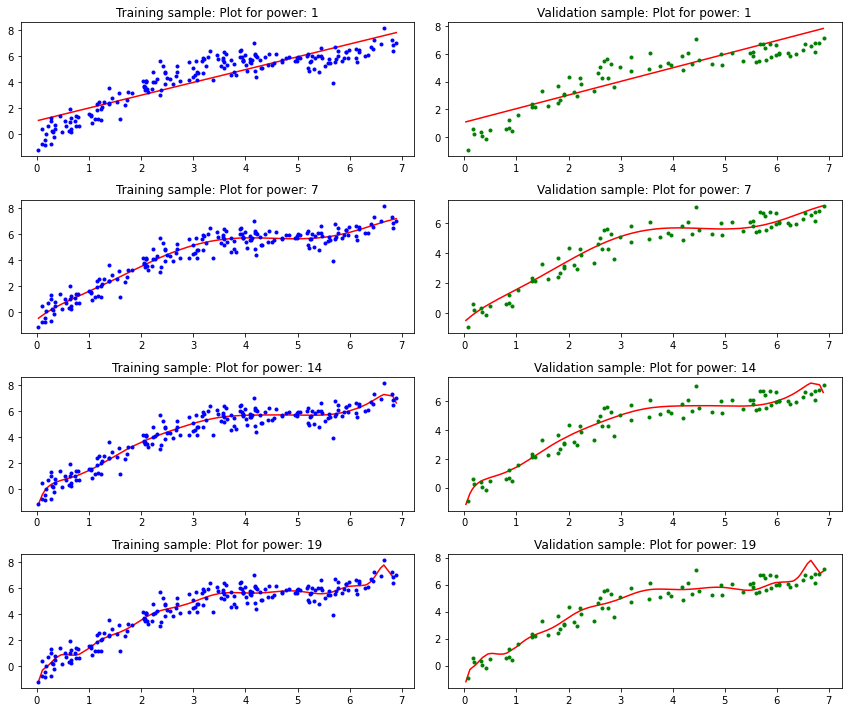

In [8]:
# This dictionary defines the orders of polynomial model 
# to plot (keys) and corresponding subplots (values)
models_to_plot = {1:421, 7:423, 14:425, 19:427}

# Iterate through all powers and assimilate results
for i in range(1,40):
    coef_matrix_simple.iloc[i-1, 0:i+3] = linear_regression(data_in, data_out, power=i, models_to_plot=models_to_plot)
coef_matrix_simple

### Illustrate the bias-variance tradeoff

The in-sample MSE (blue) and out-of-sample MSE (green) are shown for each of the models (ordered by complexity). Note that only the first 30 models are shown. The in-sample MSE (bias) is observed to decrease with complexity. For less complex models, the in-sample MSE is paradoxically observed to be higher than the out-of-sample MSE, indicating that the model is underfitting. However, for the most complex models, the out-of-sample error is significantly larger than the in-sample error (variance).

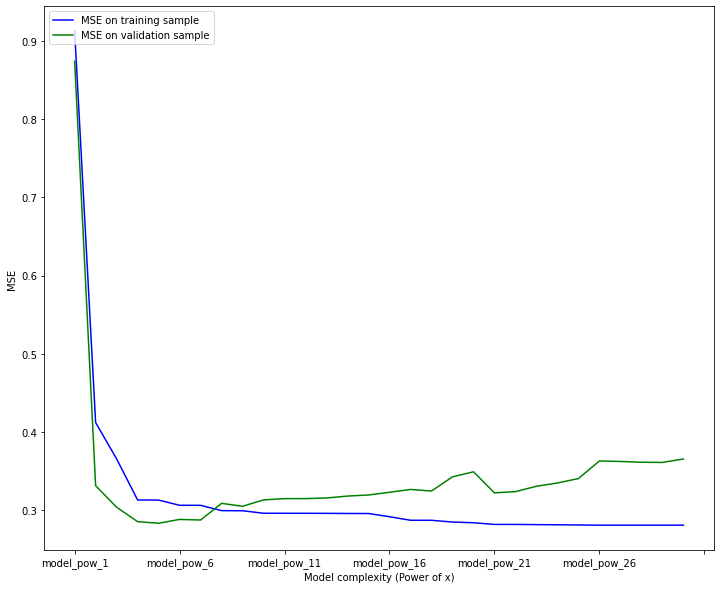

In [9]:
ax = coef_matrix_simple['rss'][0:30].plot(color='blue', label='MSE on training sample')
coef_matrix_simple['cross-rss'][0:30].plot(ax=ax, color='green',  label='MSE on validation sample')
ax.legend( loc='upper left')
ax.set_xlabel("Model complexity (Power of x)")
ax.set_ylabel("MSE");